In [1]:
import os
import multiprocessing as mp
from functools import reduce, partial

import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

import copy
import gc

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn import preprocessing

from typing import List, Dict, NoReturn, Any, Callable, Union, Optional

from preproc import import_csv

In [86]:
def dist_plot(series: pd.core.series.Series, dropna: bool = True) -> NoReturn:
    """
        Given a pandas Series, generate a descriptive visualisation 
        with a boxplot and a histogram with a kde.
        By default, this function drops `nan` values. If you desire to
        handle them differently, you should do so beforehand and/or
        specify dropna=False.
    """
    
    if dropna:
        series = series.dropna()
    
    quarts = scipy.stats.mstats.mquantiles(series, [0.001, 0.25, 0.5, 0.75, 0.975])
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    sns.boxplot(series, ax=ax_box)
    sns.stripplot(series, color="orange", jitter=0.2, size=2.5, ax=ax_box)
    sns.distplot(series, ax=ax_hist, kde=True)
    ax_hist.axvline(series.mean())
    ax_hist.set_xticks(quarts)
    #ax_box.set(xlabel=f'Mean value : {int(series.mean())}')
    plt.title(f"Glycaemic Distribution μ = {int(series.mean())}, σ = {int(series.std())}")
##

def comparative_hba1c_plot(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    hba1c: Callable = lambda x: (x + 105) / 36.5,
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "mean"
) -> NoReturn:
    """ 
    """
    
    glc_to_hba1c = lambda x: (x + 105) / 36.5
    hba1c_to_glc = lambda x: x*36.5 - 105 
    valid_kinds = ["mean", "std", "var"]
    
    if kind in valid_kinds:
        df.groupby(df.index.dayofyear)[colum_name].\
            apply(eval(f"np.{kind}")).apply(hba1c).\
                plot(**{"label":"daily"})
                
        for key, value in windows.items():
            ax = df.groupby(df.index.dayofyear)[colum_name].\
                    apply(eval(f"np.{kind}")).rolling(value).mean().\
                            apply(hba1c).plot(**{"label":key})
    
        ax.set_ylabel("HbA1c %")
        mean_hba1c = glc_to_hba1c(eval(f"df[colum_name].{kind}()"))
        secax = ax.secondary_yaxis('right', functions=(hba1c_to_glc, glc_to_hba1c))
        secax.set_ylabel('mg/dL')
        plt.axhline(mean_hba1c, **{"label": f"mean = {round(mean_hba1c,1)}", "c": "blue"})
        plt.legend()
        plt.title(f"Average {kind} of {colum_name}")
    else:
        raise Exception("kind should be `mean` (`std` or `var`)")
##

def nonull_indices(
    df: pd.DataFrame,
    column: str
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """  
    _nonull = df[column].dropna()
    _nonull = _nonull[ _nonull > 0 ]
    return _nonull.index
##

def bolus_indices(
    df: pd.DataFrame, 
    columns: Optional[List[str]] = None
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """
    
    columns = columns or ["BWZ Correction Estimate (U)",  "BWZ Carb Input (grams)"]
    _nonull = partial(nonull_indices, df)
    indices_ls = list(map(_nonull, columns))
    return reduce(lambda x, y: x.union(y), indices_ls)
##


def basal_only(df: pd.DataFrame, column: str = "Sensor Glucose (mg/dL)") -> pd.DataFrame:
    """
    """
    basal = df.copy()
    for uid in bolus_indices(basal):
        real = uid+dt.timedelta(hours=2, minutes=30)
        closest = df.index[df.index.searchsorted(real) - 1]  # Otherwise it goes out of bounds !
        basal.loc[uid:closest, column] = np.nan
    return basal
##

def hourly_trends(df: pd.DataFrame, kind: str = "mean") -> NoReturn:
    """
    """
    valid_kinds = ["mean", "std", "var"]
    
    if kind in valid_kinds:
        figs = [
            df.groupby(df.index.hour)[f'd{i}'].
                apply(eval(f"np.{kind}")).
                    plot(label=f"{i} ") 
            for i in [10, 20, 30]
        ]
        figs[-1].legend()
        plt.title(f"Hourly trends : {kind}")
        plt.xticks([i for i in range(24)])
        plt.ylabel("mg/dl")
    else:
        raise Exception(f"Invalid kind, select one from {valid_kinds}")
##        

In [3]:
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 8)

In [4]:
data = import_csv("preprocessed/CareLink-19-apr-2020-3-months.csv")

In [5]:
print("start \t:", data.index[0])
print("end \t:", data.index[-1])

start 	: 2020-01-20 04:52:00
end 	: 2020-04-19 14:04:00


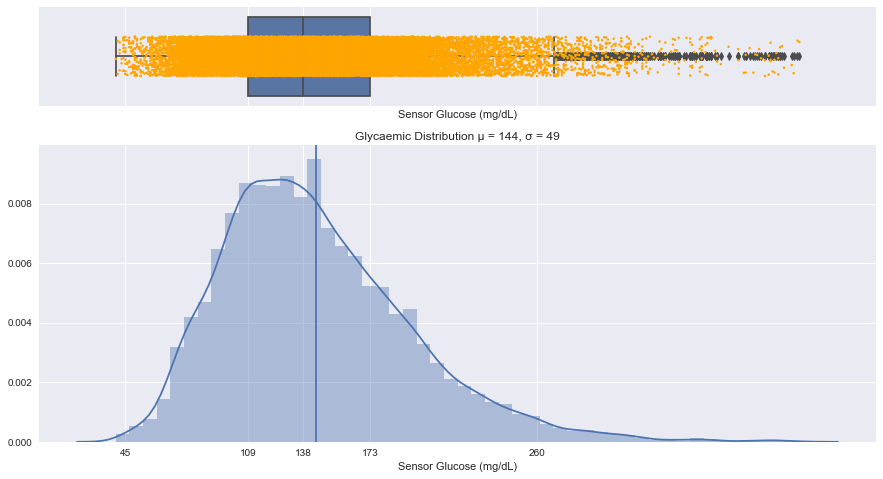

In [6]:
dist_plot(data["Sensor Glucose (mg/dL)"])

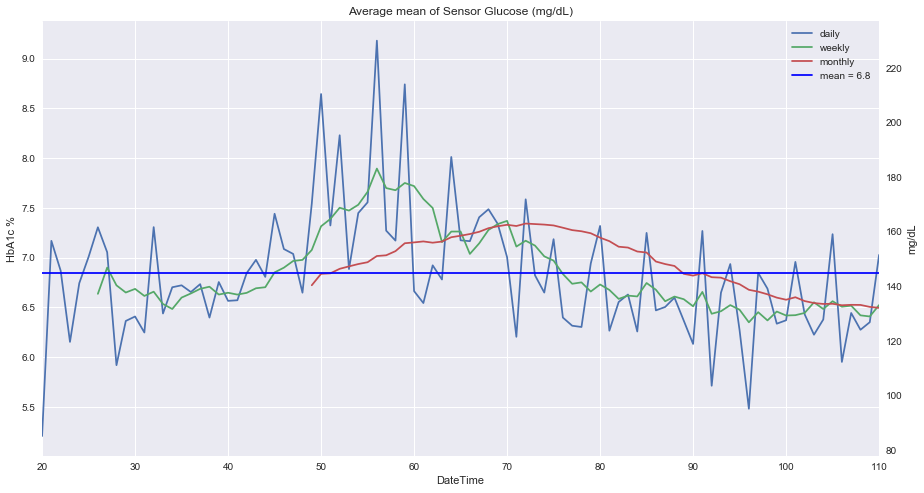

In [83]:
comparative_hba1c_plot(data, kind="mean")

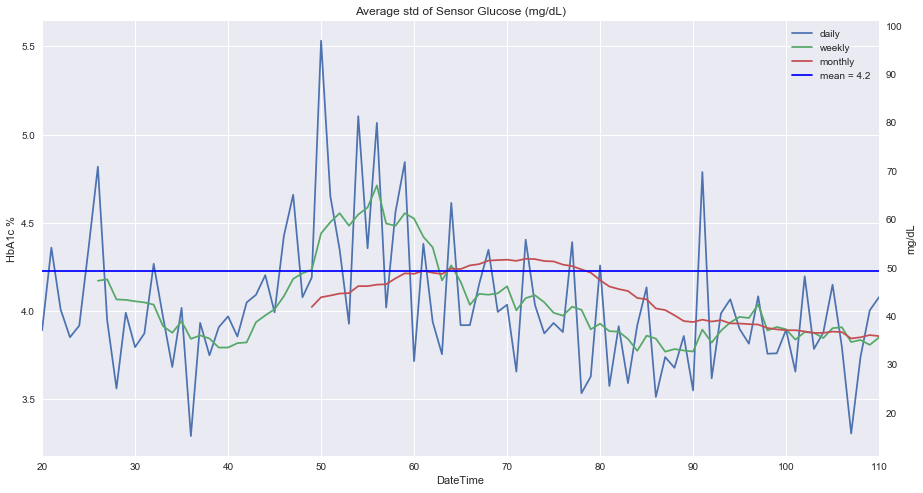

In [85]:
comparative_hba1c_plot(data, kind='std')

In [91]:
latest = data.loc["2020-04-15":"2020-04-19", :]

In [100]:
#latest.loc["2020-04-18", "Sensor Glucose (mg/dL)"].plot()

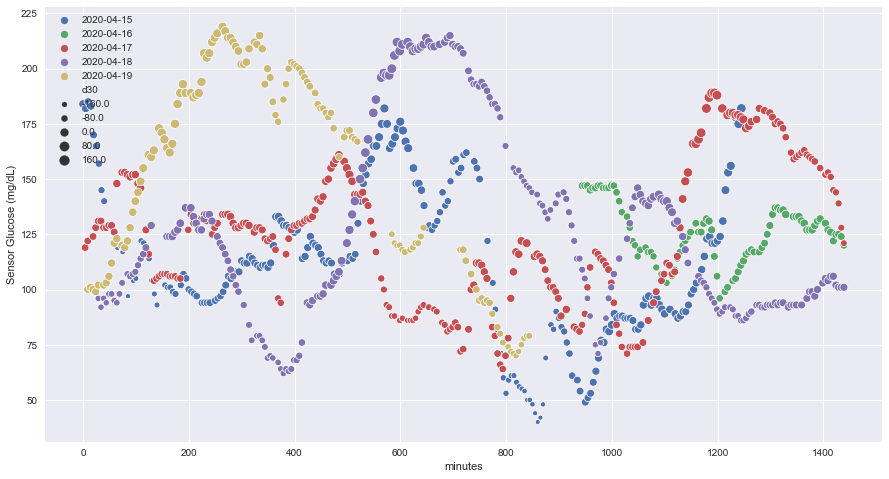

In [93]:
sns.scatterplot(
    data=latest,
    x="minutes",
    y="Sensor Glucose (mg/dL)",
    hue=latest.index.date,
    size="d30"
)

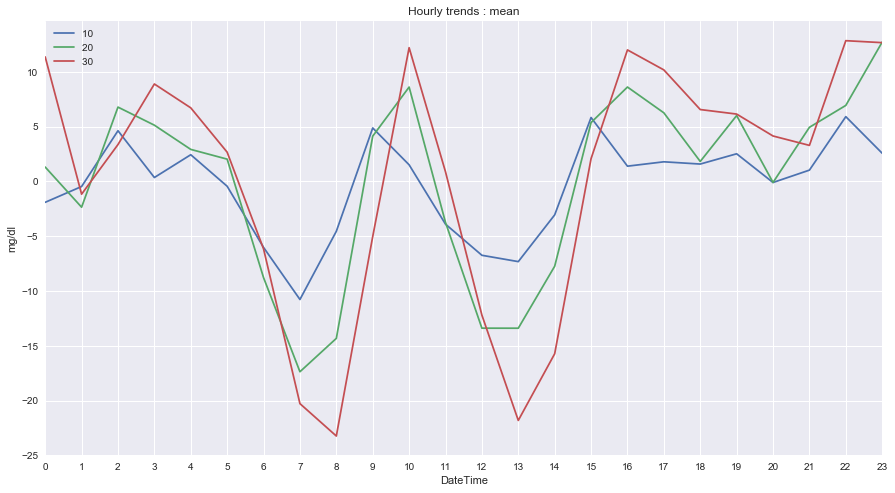

In [94]:
hourly_trends(data)

In [96]:
#hourly_trends(basal, kind="std")

In [97]:
basal = basal_only(latest)

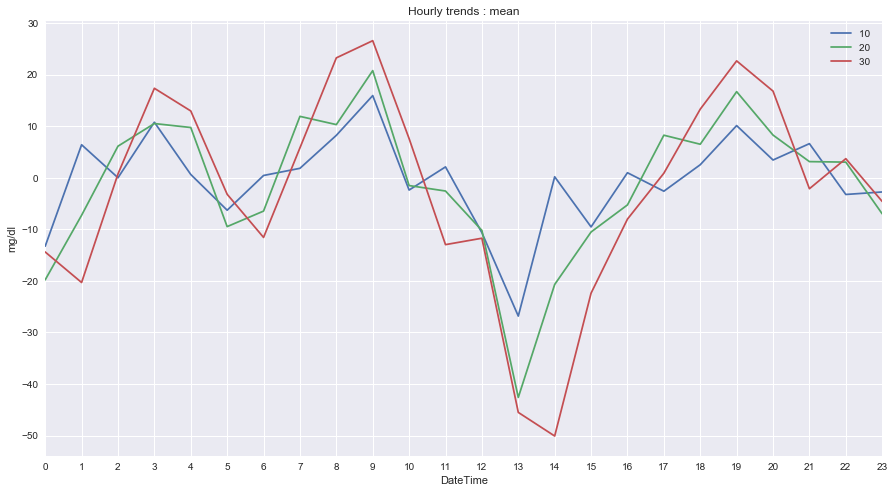

In [98]:
hourly_trends(basal)

In [99]:
#hourly_trends(basal, kind="std")